# Kernels

 
$$ \log p(\mathbf{y} \mid X, \theta) = - \frac{1}{2} \mathbf{y}^\top K_y^{-1}\mathbf{y} - \frac{1}{2} \log \lvert K \rvert - \frac{n}{2} \log 2 \pi $$

$$
\frac{\partial \log p(\mathbf{y} \mid X, \theta)}{\partial \theta_j} = \frac{1}{2} \mathbf{y}^\top K^{-1} \frac{K}{\partial \theta_j} K^{-1} \mathbf{y} - \frac{1}{2} \text{tr}   \left(K^{-1} \frac{K}{\partial \theta_j} \right) \\
= \frac{1}{2} \text{tr} \left( (\alpha \alpha^\top - K^{-1})\frac{K}{\partial \theta_j} \right)
$$

With $\alpha = K^{-1}\mathbf{y}$

TODO: what about mean: http://is.tuebingen.mpg.de/fileadmin/user_upload/files/publications/pdf2903.pdf

$$K(x,y) = e^{\textstyle \left( -\frac{1}{2\sigma^2} \lVert x-y \rVert^2 \right)} $$

$$
\frac{K}{\partial \sigma} = \frac{\lVert x-y \rVert^2}{\sigma^3} e^{\textstyle \left( -\frac{1}{2\sigma^2} \lVert x-y \rVert^2 \right)}
$$

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
import scipy.spatial
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)

In [2]:
# Define the RBF kernel
def rbf_kernel(x, y, width):
    """Radial Basis Function (RBF) kernel"""
    sqNorm = np.square(x) + np.square(y).T - 2*np.dot(x, y.T)  # (a-b)^2 = a^2 + b^2 - 2ab
    return np.exp(-(1.0/(2*width**2) * sqNorm)) #+ 1e-14 * np.eye(n1)

# Define the RBF kernel
def rbf_deriv(x, y, width):
    """Radial Basis Function (RBF) kernel"""
    sqNorm = np.square(x) + np.square(y).T - 2*np.dot(x, y.T)  # (a-b)^2 = a^2 + b^2 - 2ab
    return (sqNorm/(width**3)) * np.exp(-(1.0/(2*width**2) * sqNorm)) #+ 1e-14 * np.eye(n1)

In [3]:
# Compute the posterior mean and covariance, and sample some functions.
# Define the true function that we want to regress on
f = lambda x: np.sin(x)

n1 = 3  # Number of points to condition on (training points)
width = 1  # The width of the RBF kernel
domain = (-6, 6)

# Sample some points (X1, y1) on the function
X1 = np.random.uniform(domain[0], domain[1], size=(n1,1))
y1 = f(X1)

print 'X1', X1
print 'y1', y1

X1 [[-0.99573594]
 [ 2.64389392]
 [-5.9986275 ]]
y1 [[-0.83915946]
 [ 0.47740472]
 [ 0.28073307]]


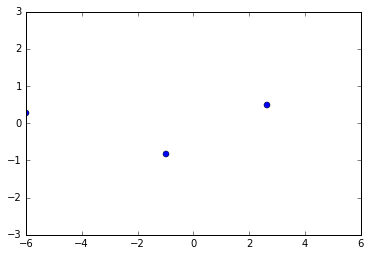

In [4]:
plt.plot(X1, y1, 'bo', linewidth=2)
plt.axis([domain[0], domain[1], -3, 3])
plt.show()

In [5]:
eps = 0.0001
param = 1
grad_func = rbf_deriv(X1, X1, param)
plus_kernel = rbf_kernel(X1, X1, param + eps)
min_kernel = rbf_kernel(X1, X1, param - eps)
# calculate numerical gradient
grad_num = (plus_kernel - min_kernel)/(2*eps)
#print 'grad_num', grad_num
#print 'grad_func', grad_func
# Raise error if the numerical grade is not close to the backprop gradient
if not np.all(np.isclose(grad_num, grad_func)):
    raise ValueError('Numerical gradient is not close to the backpropagation gradient!')
print('No gradient errors found')

No gradient errors found


$K = LL^\top$ means that $K^{-1} = L^{-\top} L^{-1}$

$(AB)^{\top} = B^{\top} A^{\top}$

## Posterior
 
$$ \log p(\mathbf{y} \mid X, \theta) = - \frac{1}{2} \mathbf{y}^\top K_y^{-1}\mathbf{y} - \frac{1}{2} \log \lvert K \rvert - \frac{n}{2} \log 2 \pi
$$

$$
\mathbf{y}^\top K_y^{-1}\mathbf{y} = \mathbf{y}^\top L^{-\top} L^{-1} \mathbf{y} \\
= (L^{-1} \mathbf{y})^\top (L^{-1} \mathbf{y}) \\
= \left(\frac{\mathbf{y}}{L^{-1}}\right)^\top \frac{\mathbf{y}}{L^{-1}}
$$

In [6]:
def posterior(y, K):
    n = K.shape[0]
    #L = np.linalg.cholesky(K)
    #yL = np.linalg.solve(L, y)  # y / L
    #det = np.linalg.det(K)
    #return -(1/2) * yL.T.dot(yL) -(1/2) * np.log(det) - (n/2) * np.log(2*np.pi)
    return -(1/2) * y.T.dot(np.linalg.inv(K)).dot(y) - (1/2) * np.log(np.linalg.det(K)) - (n/2) * np.log(2*np.pi)

## Posterior Grad
 
$$
\frac{\partial \log p(\mathbf{y} \mid X, \theta)}{\partial \theta_j} = \frac{1}{2} \mathbf{y}^\top K^{-1} \frac{K}{\partial \theta_j} K^{-1} \mathbf{y} - \frac{1}{2} \text{tr}   \left(K^{-1} \frac{K}{\partial \theta_j} \right) \\
= \frac{1}{2} \text{tr} \left( (\alpha \alpha^\top - K^{-1})\frac{K}{\partial \theta_j} \right)
$$

With $\alpha = K^{-1}\mathbf{y}$

In [7]:
def posterior_grad(y, K, Kgrad):
    print 'y', y
    KInv = np.linalg.inv(K)
    a = np.linalg.solve(K, y)  # y / K
    #a = KInv.dot(y) 
    aaK = a.dot(a.T)-KInv
    print 'aaK', aaK
    #print 'Kgrad', Kgrad
    return (1/2) * np.trace(aaK.dot(Kgrad))
    #return (1/2) * y.T.dot(KInv).dot(Kgrad).dot(KInv).dot(y) - (1/2)*np.trace(KInv.dot(Kgrad))
    #print 'np.asmatrix(y.dot(y.T))', np.asmatrix(y.dot(y.T))
    #return (1/2) * np.trace(np.asmatrix(y.dot(y.T)).dot(KInv).dot(Kgrad).dot(KInv)) - (1/2)*np.trace(KInv.dot(Kgrad))

In [8]:
eps = 0.0001
param = 1
K = rbf_kernel(X1, X1, param)
Kgrad = rbf_deriv(X1, X1, param)
print 'K.shape', K.shape
print 'Kgrad.shape', Kgrad.shape

grad_func_post = posterior_grad(y1, K, Kgrad)
plus_post = posterior(y1, rbf_kernel(X1, X1, param+eps))
min_post = posterior(y1, rbf_kernel(X1, X1, param-eps))
# calculate numerical gradient
grad_num_post = (plus_post - min_post)/(2*eps)
print 'grad_num_post', grad_num_post
print 'grad_func_post', grad_func_post
# Raise error if the numerical grade is not close to the backprop gradient
if not np.isclose(grad_num_post, grad_func_post):
    raise ValueError('Numerical gradient is not close to the backpropagation gradient!')
print('No gradient errors found')

K.shape (3, 3)
Kgrad.shape (3, 3)
y [[-0.83915946]
 [ 0.47740472]
 [ 0.28073307]]
aaK [[-0.29474383 -0.40053108 -0.23575753]
 [-0.40053108 -0.77101973  0.13433805]
 [-0.23575753  0.13433805 -0.92118721]]
grad_num_post [[-0.0070722]]
grad_func_post -0.00707220285046
No gradient errors found
